In [652]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = [8, 3] # Change default plot size
plt.rcParams["lines.linewidth"] = 1.0 # Change default line width
plt.rcParams.update({"font.size": 10}) # Change default font size

# Project 2. Enzyme kinetics and microbial growth

## Exercise 4

The following data (at steady-state) were obtained in a chemostat for the growth of *yeast* for biomass production:

<center>

| Dilution rate (h<sup>-1</sup>) | Cell concentration (g.L<sup>-1</sup>) | Carbon substrate concentration (g.L<sup>-1</sup>)|
|:-------:|:-------:|:--------:|
|  0.05   |  3.20   |  0.012   |
|  0.10   |  3.70   |  0.028   |
|  0.20   |  4.00   |  0.050   |
|  0.40   |  4.40   |  0.100   |
|  0.60   |  4.75   |  0.150   |
|  0.70   |  4.90   |  0.176   |
|  0.80   |  4.50   |  0.800   |
|  0.84   |  0.50   |  9.000   |

</center>

Note: substrate concentration in the feed is 10 g.L<sup>-1</sup> and an excess of oxygen was used.

In [653]:
D = np.array([0.05, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.84]) # Dilution rate, 1/h
X = np.array([3.2, 3.7, 4, 4.4, 4.75, 4.9, 4.5, 0.5]) # Cell concentration, g/L
S = np.array([0.012, 0.028, 0.05, 0.1, 0.15, 0.176, 0.8, 9]) # Carbon substrate concentration, g/L
S0 = 10 # Carbon substrate concentration in the feed, g/L

### Question a)
**Estimate (assuming Monod kinetics) maximum growth rate $\mu_{max}$ and Saturation/Monod constant ($K_s$).**

In a chemostrat at steady-state, the specific growth rate $\mu$ is equal to the dilution rate $D$.

Assuming Monod kinetics:
* $D = \mu_{max} \cdot \frac{S}{K_S + S}$

Because the dilution rate $D$ and the substrate concentration $S$ is known, a Lineweaver-Burke plot can be plotted with $y = \frac{1}{D}$ and $x = \frac{1}{S}$, which gives:
* $\frac{1}{D} = \frac{K_S}{\mu_{max}}\frac{1}{S} + \frac{1}{\mu_{max}}$.

Linear regression gives $\frac{K_S}{\mu_{max}}$ for the slope and $\frac{1}{\mu_{max}}$ for the intercept with the y-axis. Intercept with the x-axis is $\frac{-1}{Ks}$.

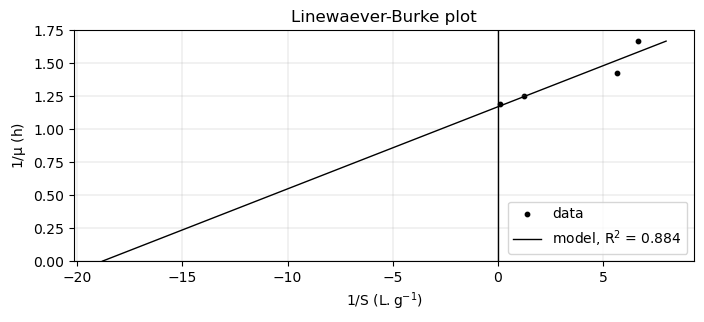

μₘₐₓ = 0.85 h⁻¹
Kₛ = 0.05 g.L⁻¹



In [654]:
def lineweaver_burke(S, D):
    """Create a Lineweaver-Burke plot and calculate mu_max, Ks ans the
    coefficient of determination of the linear regression

    Args:
        S (numpy.ndarray): substrate concentration
        D (numpy.ndarray): dilution rate

    Returns:
        mu_max (float): maximal specific growth rate
        Ks (float): Michaelis-Menten constant
    """

    x = (1/S).reshape((-1, 1))
    y = 1/D

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0] # ==> Ks/mu_max
    y_intercept = float(model.intercept_) # ==> 1/mu_max
    x_intercept = -y_intercept/slope # ==> -1/Ks
    R2 = model.score(x, y) # R^2

    mu_max = 1/y_intercept # 1/h
    Ks = -1/x_intercept # g/L

    # Create 2 points for plotting the model
    x_model = np.array([x_intercept, 1/S[0]*1.2])
    y_model = model.predict(x_model.reshape((-1, 1)))

    # --- Lineweaver-Burke plot ---
    # Lines
    plt.scatter(x, y, color = "black", s = 10.0, label = "data")
    plt.plot(x_model, y_model, color = "black", 
            label = r"model, $\mathregular{R^2}$ = " + 
            f"{round(R2, 3):.3f}")
    plt.vlines(0, 0, np.max(y_model)*1.05, color = "black")
    plt.grid(linewidth = 0.25)

    # Delimitation
    plt.ylim(0, np.max(y_model)*1.05)

    # Annotations
    plt.xlabel(r"1/S ($\mathregular{L.g^{-1}}$)")
    plt.ylabel(r"1/$\mathregular{\mu}$ (h)")
    plt.legend(loc = "lower right")
    plt.title("Linewaever-Burke plot")
    
    plt.show()

    # Saving plot in eps format
    #plt.savefig("Projects\\2. Enzyme kinetics and microbial growth\\
    # Images\\4.a.eps", format = "eps")

    return mu_max, Ks

mu_max, Ks = lineweaver_burke(S[4:], D[4:])

print(f"μₘₐₓ = {np.round(mu_max, 2)} h⁻¹\nKₛ = {np.round(Ks, 2)} g.L⁻¹\n")

### Question b)
**Estimate the yield on substrate $Y_{X/S}$ and maintenance energy $m$.**

Starting from the equation:

* $r_S$ = $\frac{r_X}{Y_{X/S}} + m \cdot X$ = $(\frac{\mu}{Y_{X/S}} + m)X$ 

The specific substrate consumption rate $q$ can be defined as the ratio between the substrate consumption rate $r_S$ and the cell concentration $X$.

Using mass balance $r_S = D \cdot (S_0 - S)$ and $r_X = D \cdot X$, this gives:

* $q = \frac{r_S}{X} = \frac{D}{Y_{X/S}} + m$.

Linear regression of $q$ over $D$ yields $\frac{1}{Y_{X/S}}$ as slope and $m$ as the intercept.

Y(X/S) = 0.52
m = 0.09 h⁻¹



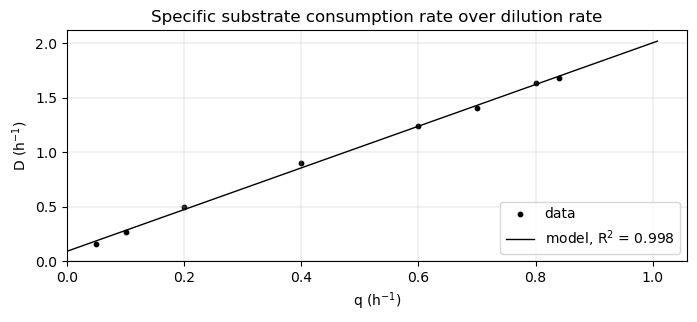

In [655]:
rS = D*(S0 - S) # Substrate consumption rate, g/L/h
rX = D*X # Growth rate, g/L/h

q = rS/X # Specific substrate consumption rate, 1/h

x = D.reshape((-1, 1))
y = q
model = LinearRegression().fit(x, y)
slope = model.coef_[0] # ==> 1/Y(X/S)
y_intercept = float(model.intercept_) # ==> m
R2 = model.score(x, y) # R^2

Y_XS = 1/slope # Yield on substrate, [-]
m = y_intercept # Maintenance energy, 1/h

print(f"Y(X/S) = {round(Y_XS, 2)}\nm = {round(m, 2)} h⁻¹\n")

# Create 2 points for plotting the model
x_model = np.array([0, D[-1]*1.2])
y_model = model.predict(x_model.reshape((-1, 1)))

# Lines
plt.scatter(x, y, color = "black", s = 10.0, label = "data")
plt.plot(x_model, y_model, color = "black", 
         label = r"model, $\mathregular{R^2}$ = " + 
         f"{round(R2, 3):.3f}")
plt.grid(linewidth = 0.25)

# Delimitation
plt.xlim(0, np.max(x_model*1.05))
plt.ylim(0, np.max(y_model)*1.05)

# Annotations
plt.xlabel(r"q ($\mathregular{h^{-1}}$)")
plt.ylabel(r"D ($\mathregular{h^{-1}}$)")
plt.legend(loc = "lower right")
plt.title("Specific substrate consumption rate over dilution rate")

plt.show()

# Saving plot in eps format
# plt.savefig("Projects\\2. Enzyme kinetics and microbial growth\\Images
# \\4.a.eps", format = "eps")

### Question c)
**You will now examine the effect of the dilution rate on the system. Ignoring the maintenance energy, derive theoretical formulas for the maximum, $D_{max}$, and optimal, $D_{opt}$, values of the dilution rate and calculate them using the parameters found in part a).**

Hint: for $D_{max}$ : under which condition does dilution rate reach its maximum (See Slide 8 of Lecture 2 to remember)?


Hint: for $D_{opt}$: if cells are our product of interest, find the best operating condition that maximizes the productivity of the cells ($D \cdot X$).

From mass balance $\mu = D$ and from Monod kinetic $\mu = \mu_{max} \cdot \frac{S}{K_S + S}$, the maximal value of $D$ is:

* $D_{max} = \mu_{max} = D \cdot (\frac{K_S}{S} + 1)$.

If the dilution rate goes further, the cells are not able to multiply fast enough to compensate for the wash-out.

In [656]:
D_max = mu_max # Maximal dilution rate, 1/h

print(f"Dₘₐₓ = {round(D_max, 2)} h⁻¹")

Dₘₐₓ = 0.85 h⁻¹


The optimal dilution rate happens when the growth rate $r_X$ ( = $D \cdot X$) is at its maximum:
 
* $\frac{d(r_X)}{dD} = 0$.

If the maintenance energy is not to be taken into account, then the growth rate is equal to the substrate consumption rate times the yield on substrate (assumed to be constant):

* $r_X = Y_{X/S} \cdot r_S$

From substrate mass balance, the substrate consumption rate can be written as:

* $r_S = D \cdot (S_0 - S)$

Which gives:

* $r_X = Y_{X/S} \cdot D(S_0 - S)$

Using Monod"s equation and the fact that $\mu = D$, the substrate concentration can be written as:

* $S = \frac{D \cdot K_S}{D_{max} - D}$

The growth rate can finally be written as:

* $r_X = Y_{X/S} \cdot D \cdot (S_0 - \frac{D \cdot K_S}{D_{max} - D})$

After derivation with respect to $D$:

* $Y_{X/S} \cdot ((S_0 - \frac{K_S \cdot D_{opt}}{D_{max} - D_{opt}}) + D_{opt} \cdot (-\frac{K_S \cdot D_{opt}}{(D_{max} - D_{opt})^2} - \frac{K_S}{D_{max} - D_{opt}})) = 0$

After isolating $D_{opt}$:

* $D_{opt} = \frac{{-\sqrt{{D_{max}^2 \cdot K_{S}^2 + D_{max}^2 \cdot K_{S} \cdot S_{0}}} + D_{max} \cdot (K_{S} + S_{0})}}{{K_{S} + S_{0}}}$

Note: second solution $\frac{{\sqrt{{D_{max}^2 \cdot K_{S}^2 + D_{max}^2 \cdot K_{S} \cdot S_{0}}} + D_{max} \cdot (K_{S} + S_{0})}}{{K_{S} + S_{0}}}$ also exists but would find a minimum (the function found for $r_X$ isn't continuous).

In [657]:
def calc_D_opt(D_max, Ks, S0):
    """Calculate the theoretical optimal dilution rate (neglige maintenance energy)

    Args:
        D_max (float): maximal dilution rate
        Ks (float): Michaelis-Menten constant
        S0 (float): substrate concentration in the feed

    Returns:
        D_opt (float): optimal dilution rate
    """
    D_opt = (-np.sqrt(D_max**2*Ks**2 + D_max**2*Ks*S0) + D_max*Ks + D_max*S0)/(Ks + S0)

    return D_opt

D_opt = calc_D_opt(D_max, Ks, S0)
print(f"Dₒₚₜ = {round(D_opt, 2)} h⁻¹")

Dₒₚₜ = 0.79 h⁻¹


### Question d)
**Based on the values in question c) define a range for $D$. Use the estimated values in question a) and b) to compute the substrate and cell concentrations as a function of dilution rate (do not neglect maintenance energy).**

The operating range for $D$ is between 0 and $D_{max}$.

Computation of substrate concentration as a function of dilution rate is easily doable using the Monod"s equation:

* $S = D \cdot \frac{K_s}{D_{max} - D}$

Computation of cell concentration as a function can be done by first expressing the consumption rate of substrate as a function of $[D]$ and $X$:

* $r_S = D \cdot \frac{X}{Y_{X/S}} + m \cdot X$

Using the substrate mass balance, $r_S$ can be written as a function of $D$ and $S$ as well:

* $r_S = D \cdot (S_0 - S)$

By replacing $S$ with the expression found before:

* $r_S = D \cdot (S_0 - D \cdot \frac{K_s}{D_{max} - D})$

Which yields this equality:

* $D(S_0 - D \cdot \frac{K_s}{D_{max} - D}) = D \cdot \frac{X}{Y_{X/S}} + m \cdot X$

Isolating $X$ gives:

* $X = D \cdot Y_{X/S} \cdot \frac{D \cdot (K_S + S_0) - D_{max} \cdot S_0}{(D - D_{max}) \cdot (D + m \cdot Y_{X/S})}$

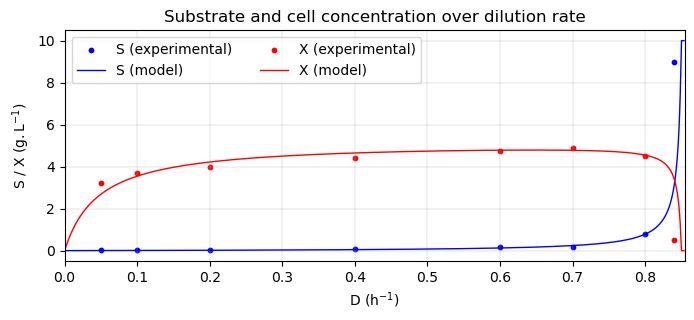

In [658]:
def calc_S(D, Ks, D_max):
    """Calculate theoretical substrate concentration as a function of
    dilution rate

    Args:
        D (numpy.ndarray): dilution rate
        Ks (float): Michaelis-Menten constant
        D_max (float): maximal dilution rate

    Returns:
        S (numpy.ndarray): substrate concentration
    """
    S = D*Ks/(D_max - D)

    return np.where(S <= S0, S, S0)

def calc_X(D, Ks, S0, D_max, Y_XS, m):
    """Calculate theoretical cell concentration as a function of 
    dilution ratwe

    Args:
        D (numpy.ndarray): dilution rate
        Ks (float): Michaelis-Menten constant
        S0 (float): substrate concentration in the feed
        D_max (float): maximal dilution rate
        Y_XS (float): yield on substrate coefficient
        m (float): maintenance energy

    Returns:
        X (numpy.ndarray): cell concentration
    """
    X = (D*Y_XS*(D*(Ks + S0) - D_max*S0))/((D - D_max)*(D + m*Y_XS))
    
    return np.where(X >= 0, X, 0)

D_model = np.linspace(0, D_max, 1000)[:-1] # Last value ignored to prevent dividing by 0
S_model = calc_S(D_model, Ks, D_max)
X_model = calc_X(D_model, Ks, S0, D_max, Y_XS, m)

# Lines
plt.scatter(D, S, color = 'blue', s = 10.0, label = 'S (experimental)')
plt.plot(D_model, S_model, color = 'blue', label = 'S (model)')
plt.scatter(D, X, color = 'red', s = 10.0, label = 'X (experimental)')
plt.plot(D_model, X_model, color = 'red', label = 'X (model)')
plt.grid(linewidth = 0.25)

# Delimitations
plt.xlim(0, D_max)

# Annotations
plt.xlabel(r"D ($\mathregular{h^{-1}}$)")
plt.ylabel(r"S / X ($\mathregular{g.L^{-1}}$)")
plt.legend(ncol = 2)
plt.title("Substrate and cell concentration over dilution rate")

plt.show()

# Saving plot in eps format
# plt.savefig("Projects\\2. Enzyme kinetics and microbial growth\\Images
# \\4.d.eps", format = "eps")

## Question e)

**Use the estimated values in part a) and b) to calculate the productivity of the cells $X$ as a function of dilution rate $D$. Repeat this productivity computation for different values of $K_S$. What happens when $K_s$ is increased (do not neglect maintenance energy)?**

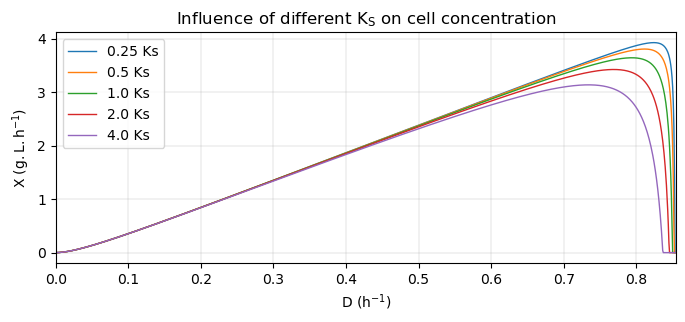

In [659]:
def calc_prod(D, Ks, S0, D_max, Y_XS, m):
    """Calculate productivity as a function of dilution rate

    Args:
        D (numpy.ndarray): dilution rate
        X (numpy.ndarray): cell concentration

    Returns:
        prod (numpy.ndarray): productivity
    """
    X = calc_X(D, Ks, S0, D_max, Y_XS, m)
    prod = D*X

    return prod

# Create multiple Ks
Ks_model = np.array([Ks/4, Ks/2, Ks, Ks*2, Ks*4])

# Calculate productivity for each Ks
for x in range(len(Ks_model)):
    prod_model = calc_prod(D_model, Ks_model[x], S0, D_max, Y_XS, m) # g/L/h

    # Lines
    plt.plot(D_model, prod_model, label = f'{Ks_model[x]/Ks} Ks')
plt.grid(linewidth = 0.25)

# Delimitations
plt.xlim(0, D_max)

# Annotations
plt.xlabel(r"D ($\mathregular{h^{-1}}$)")
plt.ylabel(r"X ($\mathregular{g.L.h^{-1}}$)")
plt.legend()
plt.title(r"Influence of different $\mathregular{K_S}$ on cell concentration")

plt.show()

# Saving plot in eps format
# plt.savefig("Projects\\2. Enzyme kinetics and microbial growth\\Images
# \\4.e.eps", format = "eps")

## Question f)

**Find the maximum productivity and the corresponding dilution rate with the constant $K_S$ found in a).**

In [660]:
prod_model = calc_prod(D_model, Ks, S0, D_max, Y_XS, m)
prod_max_model = float(np.max(prod_model))
D_opt_model = D_model[prod_model == prod_max_model][0]
index = np.where(prod_model == prod_max_model)[0][0]

print(f"prodₘₐₓ = {round(prod_max_model, 2)} g.L⁻¹.s⁻¹\nDₒₚₜ = {round(D_opt_model, 2)} h⁻¹")

prodₘₐₓ = 3.64 g.L⁻¹.s⁻¹
Dₒₚₜ = 0.79 h⁻¹


## Question g)

**Compare the $D_{opt}$ from question c) with the one obtained in question f).**

In [661]:
print(f"Dₒₚₜ (analytical) = {round(D_opt, 2)} h⁻¹\nDₒₚₜ (model) = {round(D_opt_model, 2)} h⁻¹")

Dₒₚₜ (analytical) = 0.79 h⁻¹
Dₒₚₜ (model) = 0.79 h⁻¹


## Chemostat model

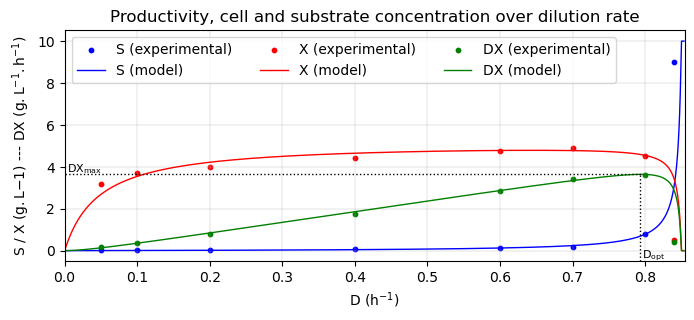

In [662]:
prod = D*X

# Lines
plt.scatter(D, S, s = 10.0, color = "blue", label = "S (experimental)")
plt.plot(D_model, S_model, color = "blue", label = 'S (model)')
plt.scatter(D, X, s = 10.0, color = "red", label = 'X (experimental)')
plt.plot(D_model, X_model, color = "red", label = 'X (model)')
plt.scatter(D, prod, s = 10.0, color = "green", label = 'DX (experimental)')
plt.plot(D_model, prod_model, color = "green", label = 'DX (model)')
plt.hlines(prod_max_model, 0, D_opt_model, color = "black", linestyle = ":")
plt.vlines(D_opt, -S0/20, prod_max_model, color = "black", linestyle = ":")
plt.grid(linewidth = 0.25)

# Delimitations
plt.xlim(0, D_max)
plt.ylim(bottom = -S0/20)

#Annotations
plt.annotate(r"$\mathregular{DX_{max}}$", xy = (0, prod_max_model), 
             xytext = (2, 2), textcoords = "offset points", size = 8.0)
plt.annotate(r"$\mathregular{D_{opt}}$", xy = (D_opt, -S0/20), xytext = (2, 2), 
             textcoords = "offset points", size = 8.0)
plt.xlabel(r"D ($\mathregular{h^{-1}}$)")
plt.ylabel(r"S / X ($\mathregular{g.L{-1}}$) --- DX ($\mathregular{g.L^{-1}.h^{-1}}$)")
plt.legend(loc = "upper left", ncol = 3)
plt.title(r"Productivity, cell and substrate concentration over dilution rate")

plt.show()

# plt.savefig("Projects\\2. Enzyme kinetics and microbial growth\\Images
# \\chemostat.eps", format = "eps")